# Homework 1

In [1]:
# Configurations
import matplotlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(111)
%matplotlib inline

## 1 - Utils functions

In [2]:
# From: http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def plot_for_KDE(probs):
    plt.figure(figsize=(13, 3), dpi=500)
    plt.plot(np.arange(len(probs)), probs)
    plt.xlabel('Instances')
    plt.ylabel('f(x)')
    plt.title('PDF - data')
    
def performance_measures(true_positives,true_negatives,false_positives, false_negatives):   
    accuracy  = (true_positives + true_negatives)/(true_positives + true_negatives + false_positives + false_negatives)
    precision = true_positives/(true_positives + false_positives)
    recall = true_positives/ (true_positives + false_negatives)
    f1 = 2*(precision*recall)/(precision + recall)
    return accuracy, precision, recall, f1

## 2. Loading the data to pandas and split for training and test:

In [3]:
# Load the data
import scipy.io
d_mat = scipy.io.loadmat("data/oc_514.mat")
d_mat = d_mat['x'][0,0]
dataset = pd.DataFrame(np.hstack((d_mat[0],d_mat[2])), columns = np.append([x.strip() for x in d_mat[5]], ["class"]))
dataset["class"] = dataset["class"].astype("category")
dataset["class"].cat.rename_categories(["anomaly", "normal"], inplace = True)

dataset.head()

,age,sex,height,weight,QRS duration,P-R interval,Q-T interval,T interval,P interval,QRS,...,V6-Q wave ampl,V6-R wave ampl,V6-S wave ampl,V6-R' wave ampl,V6-S' wave ampl,V6-P wave ampl,V6-T wave ampl,V6-QRSA sum,V6-QRSTA,class
0,75.0,0.0,190.0,80.0,91.0,193.0,371.0,174.0,121.0,-16.0,...,0.0,9.0,-0.9,0.0,0.0,0.9,2.9,23.3,49.4,anomaly
1,56.0,1.0,165.0,64.0,81.0,174.0,401.0,149.0,39.0,25.0,...,0.0,8.5,0.0,0.0,0.0,0.2,2.1,20.4,38.8,anomaly
2,54.0,0.0,172.0,95.0,138.0,163.0,386.0,185.0,102.0,96.0,...,0.0,9.5,-2.4,0.0,0.0,0.3,3.4,12.3,49.0,anomaly
3,55.0,0.0,175.0,94.0,100.0,202.0,380.0,179.0,143.0,28.0,...,0.0,12.2,-2.2,0.0,0.0,0.4,2.6,34.6,61.6,normal
4,13.0,0.0,169.0,51.0,100.0,167.0,321.0,174.0,91.0,107.0,...,-0.6,12.2,-2.8,0.0,0.0,0.9,2.2,13.5,31.1,anomaly


### Spliting the data for training and test:

In [4]:
from sklearn.model_selection import train_test_split

X = dataset.ix[:,:278]
y = dataset.ix[:,278]

X_train, X_test, y_train, y_test = train_test_split(dataset.ix[:,:278], dataset.ix[:,278], test_size=0.3, random_state=111)
X_train_normal = X_train[y_train != "anomaly"]


## 3) KDE

Instructions: Kernel Density Estimation with Gaussian kernel (use scikit-learn or try to implement it yourself)

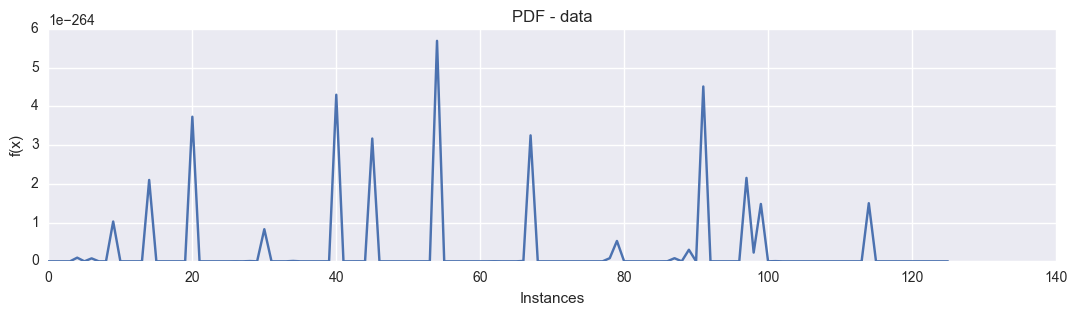

In [5]:
from sklearn.neighbors.kde import KernelDensity

#Calculate probabilities 

#hist = KernelDensity(kernel = "guassian", brandwith = 0.2)
model = KernelDensity(kernel = "gaussian", bandwidth = 3.1)    
model.fit(X_train_normal)
results = np.exp(model.score_samples(X_test))

# make predictions
y_pred = np.array(["anomaly" if y == 0.0 else "normal" for y in results])

plot_for_KDE(results)

Confusion matrix, without normalization
[[26 38]
 [15 47]]


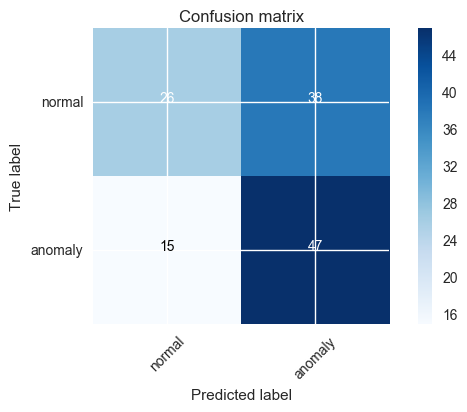

In [6]:
from sklearn.metrics import confusion_matrix
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels = ["normal", "anomaly"]), classes = ["normal", "anomaly"])

### Performance measures

In [7]:
# positive = anomaly
true_positives = 39
true_negatives = 15
false_positives = 61
false_negatives = 11

# accuracy = correct/total

accuracy, precision, recall, f1 = performance_measures(
    true_positives, 
    true_negatives, 
    false_positives,
    false_negatives)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.42857142857142855
0.39
0.78
0.5200000000000001


#### Conclusions:
Poor performance. Very low accuracy.


# 4) One-class SVM

Instruction: One-Class SVM (use scikit-learn or try to implement it yourself)

Confusion matrix, without normalization
[[28 36]
 [22 40]]


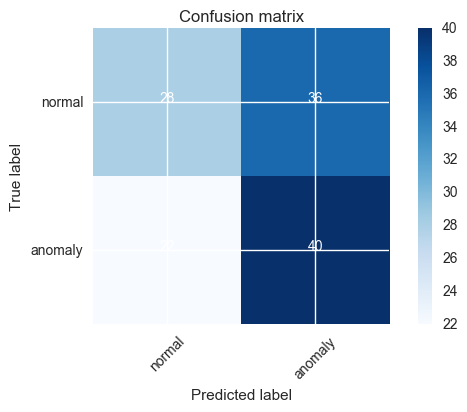

In [8]:
from sklearn import svm

model = svm.OneClassSVM(kernel="linear")
model.fit(X_train_normal)
y_pred = np.array(["anomaly" if y == 1 else "normal" for y in model.predict(X_test)])

plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels = ["normal", "anomaly"]), classes = ["normal", "anomaly"])

### Performance measure

In [9]:
# positive = anomaly
true_positives = 30
true_negatives = 36
false_positives = 20
false_negatives = 40

# accuracy = correct/total

accuracy, precision, recall, f1 = performance_measures(
    true_positives, 
    true_negatives, 
    false_positives,
    false_negatives)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.5238095238095238
0.6
0.42857142857142855
0.5


#### Conclusions:
- Better performance when compared to KDE, still poor performance and low accuracy . 

### 3) LOF

Instruction: Local Outlier Factor (try to implement it yourself)

In [10]:
from sklearn.neighbors import NearestNeighbors
import scipy.spatial.distance as scidi 

class LOF:
    def __init__(self, train_data, k):
        self.train_data = train_data
        self.nearest_neighbors = NearestNeighbors(n_neighbors = k, metric = "euclidean")
        self.nearest_neighbors.fit(train_data)
    
    def neighbors(self, a):
        return(self.nearest_neighbors.kneighbors([a]))
    
    def number_of_neighbors(self, a):
        return(len(self.neighbors(a)[0][0]))
    
    def k_distance(self, a):
        dist, i = self.neighbors(a)
        return(max(dist[0]))
    
    def reachability_distance(self, a, b):
        return(max([self.k_distance(b), scidi.euclidean(a, b)]))
    
    def lrd(self, a):
        neighbors_dist, neighbors_i = self.neighbors(a)
        return(1/(sum([self.reachability_distance(a, b) for b in self.train_data.iloc[neighbors_i[0],:].values])/self.number_of_neighbors(a)))
    
    def lof(self, a):
        neighbors_dist, neighbors_i = self.neighbors(a)
        return(sum([(self.lrd(b) / self.lrd(a)) for b in self.train_data.iloc[neighbors_i[0], :].values])/self.number_of_neighbors(a))
    
    def predict(self, test_data):
        return([self.lof(x) for i, x in test_data.iterrows()])

In [11]:
model = LOF(X_train_normal, 5)
model_prediction = model.predict(X_test)
y_pred = np.array(["anomaly" if y > 1.2 else "normal" for y in model_prediction])

Confusion matrix, without normalization
[[47 17]
 [23 39]]


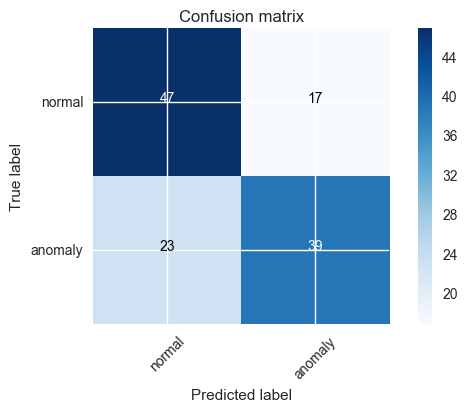

In [12]:
plot_confusion_matrix(confusion_matrix(y_test, y_pred, labels = ["normal", "anomaly"]), classes = ["normal", "anomaly"])

# Performance measure

In [13]:
# positive = anomaly
true_positives = 28
true_negatives = 56
false_positives = 22
false_negatives = 20

# accuracy = correct/total

accuracy, precision, recall, f1 = performance_measures(
    true_positives, 
    true_negatives, 
    false_positives,
    false_negatives)

print(accuracy)
print(precision)
print(recall)
print(f1)

0.6666666666666666
0.56
0.5833333333333334
0.5714285714285714


#### Conclusions:
- The LOF proved to be the best of all the analysed algorithms and it got improvement in all performance measures.